

---


# 🚑🚒 **Classificando Sons de Veículos de Emergência** 🚑🚒

Ana Ellen Deodato P Silva		 						800206  
Vinicius de Oliveira Guimarães 							802431  
Vinícius Gonçalves Perillo 								800219  



---


# 📊 **Dados das imagens** 📊

Olhando os arquivos, temos para:

* **Treino**: 1600 imagens, 800 de cada espécie
* **Validação**: 414 imagens, 207 de cada espécie
* **Teste**: 5 imagens de coelhos e 10 de gatos


### Importação das imagens

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'emergency-vehicle-siren-sounds:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F471473%2F2360426%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240202%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240202T013037Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D92ef9d337398a1772b78a40538cd7f42ab500a1a31b683d38789902ded678174cc3d6a2ddc3a593a78077dce22972c7cd7caf2070614a29a5650e2665cc2d9af97720a1b1315418e0c44cd54388e7e820b8c679b09692d57a86d686789b94dfc248305f6058b345d47ed3347595e85cedafff6685c2ce718e16e83b6b4a90b57f305c79bb646be6f2f313a87dd47ebc461e2c137c78b1f200c42f24f0176cbc2c05cc50b39fc7202e0341329b9ea4b9808e9c2d431bb494336b38cbca7923aea05f6e1c490b78f378bc5d57a37374324ecd27973c56bbbee648eee7fa35a3e0ce84084eaec9c37e8418918c7cdfd2899ed9524ed8db4de22dc0269bfba071933'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 295449435 bytes downloaded
Downloaded and uncompressed: emergency-vehicle-siren-sounds
Data source import complete.


In [ ]:
# Common
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Sound Processing
import librosa

# Data
import cv2 as cv
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Data Augmentation
from keras.models import Sequential
from keras.layers import Input
from tensorflow.keras.layers import *
# Model Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint


Como não temos experiência com importação de imagens, usamos um código pronto:

Créditos para - [clique aqui](https://www.kaggle.com/code/utkarshsaxenadn/catvsrabbit-classification-mobilenet-acc-100)

In [ ]:
!cd /kaggle/input/emergency-vehicle-siren-sounds/sounds/ambulance/; rm *.png; rm *.py
!cd /kaggle/input/emergency-vehicle-siren-sounds/sounds/firetruck/; rm *.png; rm *.py
!cd /kaggle/input/emergency-vehicle-siren-sounds/sounds/traffic/; rm *.png; rm *.py

In [ ]:
root = os.path.join('/kaggle/input/emergency-vehicle-siren-sounds/sounds/', '')

ambulance_sounds_paths = os.listdir(os.path.join(root,'ambulance/'))
firetruck_sounds_paths = os.listdir(os.path.join(root, 'firetruck/'))
traffic_sounds_paths = os.listdir(os.path.join(root, 'traffic/'))


In [ ]:
amb_sounds = []
fir_sounds = []
tra_sounds = []

for s in ambulance_sounds_paths:
    y, sr = librosa.load(os.path.join(root, 'ambulance/', s))
    amb_sounds.append((y, sr, 'ambulance'))

for s in firetruck_sounds_paths:
    y, sr = librosa.load(os.path.join(root, 'firetruck/', s))
    fir_sounds.append((y, sr, 'firetruck'))

for s in traffic_sounds_paths:
    y, sr = librosa.load(os.path.join(root, 'traffic/', s))
    tra_sounds.append((y, sr, 'traffic'))

In [ ]:
len(amb_sounds)

200



---


# 📈 **Pré Processamento** 📈

In [ ]:
amb_train, amb_test = np.split(np.random.permutation(amb_sounds), [150])
fir_train, fir_test = np.split(np.random.permutation(fir_sounds), [150])
tra_train, tra_test = np.split(np.random.permutation(tra_sounds), [150])

<ipython-input-8-c26bd5343322>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  amb_train, amb_test = np.split(np.random.permutation(amb_sounds), [150])
<ipython-input-8-c26bd5343322>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fir_train, fir_test = np.split(np.random.permutation(fir_sounds), [150])
<ipython-input-8-c26bd5343322>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

## Aumento dos Dados

### Pink Noise


In [ ]:
def generate_pink_noise(duration_sec, sample_rate):
    num_samples = int(duration_sec * sample_rate)
    pink_noise = np.random.randn(num_samples)
    pink_noise = np.cumsum(pink_noise)
    pink_noise -= np.mean(pink_noise)
    pink_noise /= np.max(np.abs(pink_noise))

    return pink_noise

def apply_pink_noise(audio, sr, lable):
    pink_noise = generate_pink_noise(len(audio) / sr, sr)
    pink_noise = pink_noise[:len(audio)]
    mixed_audio = audio + 0.5 * pink_noise

    return (mixed_audio, sr, label)

In [ ]:
amb_pink = []
fir_pink = []
tra_pink = []

for audio, sr, label in np.random.permutation(amb_train)[:50]:
    amb_pink.append(apply_pink_noise(audio, sr, label))

for audio, sr, label in np.random.permutation(fir_train)[:50]:
    fir_pink.append(apply_pink_noise(audio, sr, label))

for audio, sr, label in np.random.permutation(tra_train)[:50]:
    tra_pink.append(apply_pink_noise(audio, sr, label))


In [ ]:
len(amb_pink)

50

### Gaussian Noise

In [ ]:
def apply_gaussian_noise(audio, sr, label):
    gaussian_noise = np.random.normal(0, 0.005, len(audio))
    mixed_audio = audio + gaussian_noise

    return (mixed_audio, sr, label)

In [ ]:
amb_gaussian = []
fir_gaussian = []
tra_gaussian = []

for audio, sr, label in np.random.permutation(amb_train)[:50]:
    amb_gaussian.append(apply_gaussian_noise(audio, sr, label))

for audio, sr, label in np.random.permutation(fir_train)[:50]:
    fir_gaussian.append(apply_gaussian_noise(audio, sr, label))

for audio, sr, label in np.random.permutation(tra_train)[:50]:
    tra_gaussian.append(apply_gaussian_noise(audio, sr, label))

### Gain/Random power

In [ ]:
def apply_gain(audio, sr, label):
    mixed_audio = audio * np.random.uniform(0.5, 1.5)

    return (mixed_audio, sr, label)

In [ ]:
amb_gain = []
fir_gain = []
tra_gain = []

for audio, sr, label in np.random.permutation(amb_train)[:50]:
    amb_gain.append(apply_gain(audio, sr, label))

for audio, sr, label in np.random.permutation(fir_train)[:50]:
    fir_gain.append(apply_gain(audio, sr, label))

for audio, sr, label in np.random.permutation(tra_train)[:50]:
    tra_gain.append(apply_gain(audio, sr, label))



### TanH Distortion

In [ ]:
def apply_tanh_distortion(audio, sr, label):
    distorted_audio = np.tanh(2 * audio)
    distorted_audio /= np.max(np.abs(distorted_audio))

    return (distorted_audio, sr, label)

In [ ]:
amb_tanh = []
fir_tanh = []
tra_tanh = []

for audio, sr, label in np.random.permutation(amb_train)[:50]:
    amb_tanh.append(apply_tanh_distortion(audio, sr, label))

for audio, sr, label in np.random.permutation(fir_train)[:50]:
    fir_tanh.append(apply_tanh_distortion(audio, sr, label))

for audio, sr, label in np.random.permutation(tra_train)[:50]:
    tra_tanh.append(apply_tanh_distortion(audio, sr, label))

### Adicionando ao conjunto teste

In [ ]:
amb_train = np.concatenate([amb_train, amb_pink])
fir_train = np.concatenate([fir_train, fir_pink])
tra_train = np.concatenate([tra_train, tra_pink])

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
amb_train = np.concatenate([amb_train, amb_gaussian])
fir_train = np.concatenate([fir_train, fir_gaussian])
tra_train = np.concatenate([tra_train, tra_gaussian])

In [ ]:
amb_train = np.concatenate([amb_train, amb_gain])
fir_train = np.concatenate([fir_train, fir_gain])
tra_train = np.concatenate([tra_train, tra_gain])

In [ ]:
#amb_train = np.concatenate([amb_train, amb_tanh])
#fir_train = np.concatenate([fir_train, fir_tanh])
#tra_train = np.concatenate([tra_train, tra_tanh])

## Mel Espectograma

In [ ]:
train = np.concatenate([amb_train, fir_train, tra_train])
test = np.concatenate([amb_test, fir_test, tra_test])



In [ ]:
def get_melspec(inp: tuple):
    y, sr, _ = inp

    mel_spec = librosa.feature.melspectrogram(y= y, sr= sr, hop_length= 1024)
    mel_spec[mel_spec == 0] = np.finfo(float).eps
    mel_spec = np.log(mel_spec)

    return mel_spec


In [ ]:
train_mel = []
test_mel = []

for i in train:
    train_mel.append(get_melspec(i))

for i in test:
    test_mel.append(get_melspec(i))

In [ ]:
train_df = pd.DataFrame(train, columns= ['y','sr','label'])
train_df['mel'] = train_mel
test_df = pd.DataFrame(test, columns= ['y','sr','label'])
test_df['mel'] = test_mel

In [ ]:
train_df['label'] = train_df['label'].map({'ambulance': 0, 'firetruck': 1, 'traffic': 2})
test_df['label'] = test_df['label'].map({'ambulance': 0, 'firetruck': 1, 'traffic': 2})

In [ ]:
train_df = train_df.sample(frac=1.0)
test_df = test_df.sample(frac=1.0)

### Uma amostra

In [ ]:
class_names = ['ambulance', 'firetruck', 'traffic']

In [ ]:
def show_images(images:list, labels:list, class_names:list, model:None = None, GRID:tuple = (5,6), SIZE:tuple = (30,25)) -> None:
    # Plotting Configuration
    plt.figure(figsize=SIZE)
    n_rows, n_cols = GRID[0], GRID[1]
    n_images = n_rows * n_cols

    # Iterate through the Plot
    for i in range(1, n_images+1):
        # Select image & label randomly
        index = np.random.randint(len(images))
        image, label = images[index], labels[index]
        title = class_names[int(label)]

        # Plot the Image
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(tf.squeeze(image))
        plt.title(title.title())
        plt.axis('off')

    # Show Final Figure
    plt.show()

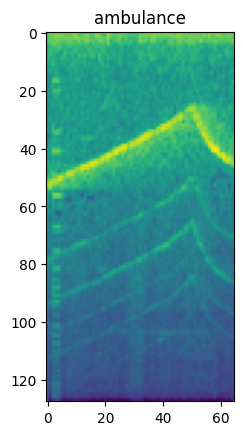

(128, 65)


In [ ]:
i = np.random.randint(1050)

plt.figure()
plt.imshow(train_df['mel'][i])
plt.title(class_names[train_df['label'][i]])
plt.show()

print(train_df['mel'][i].shape)

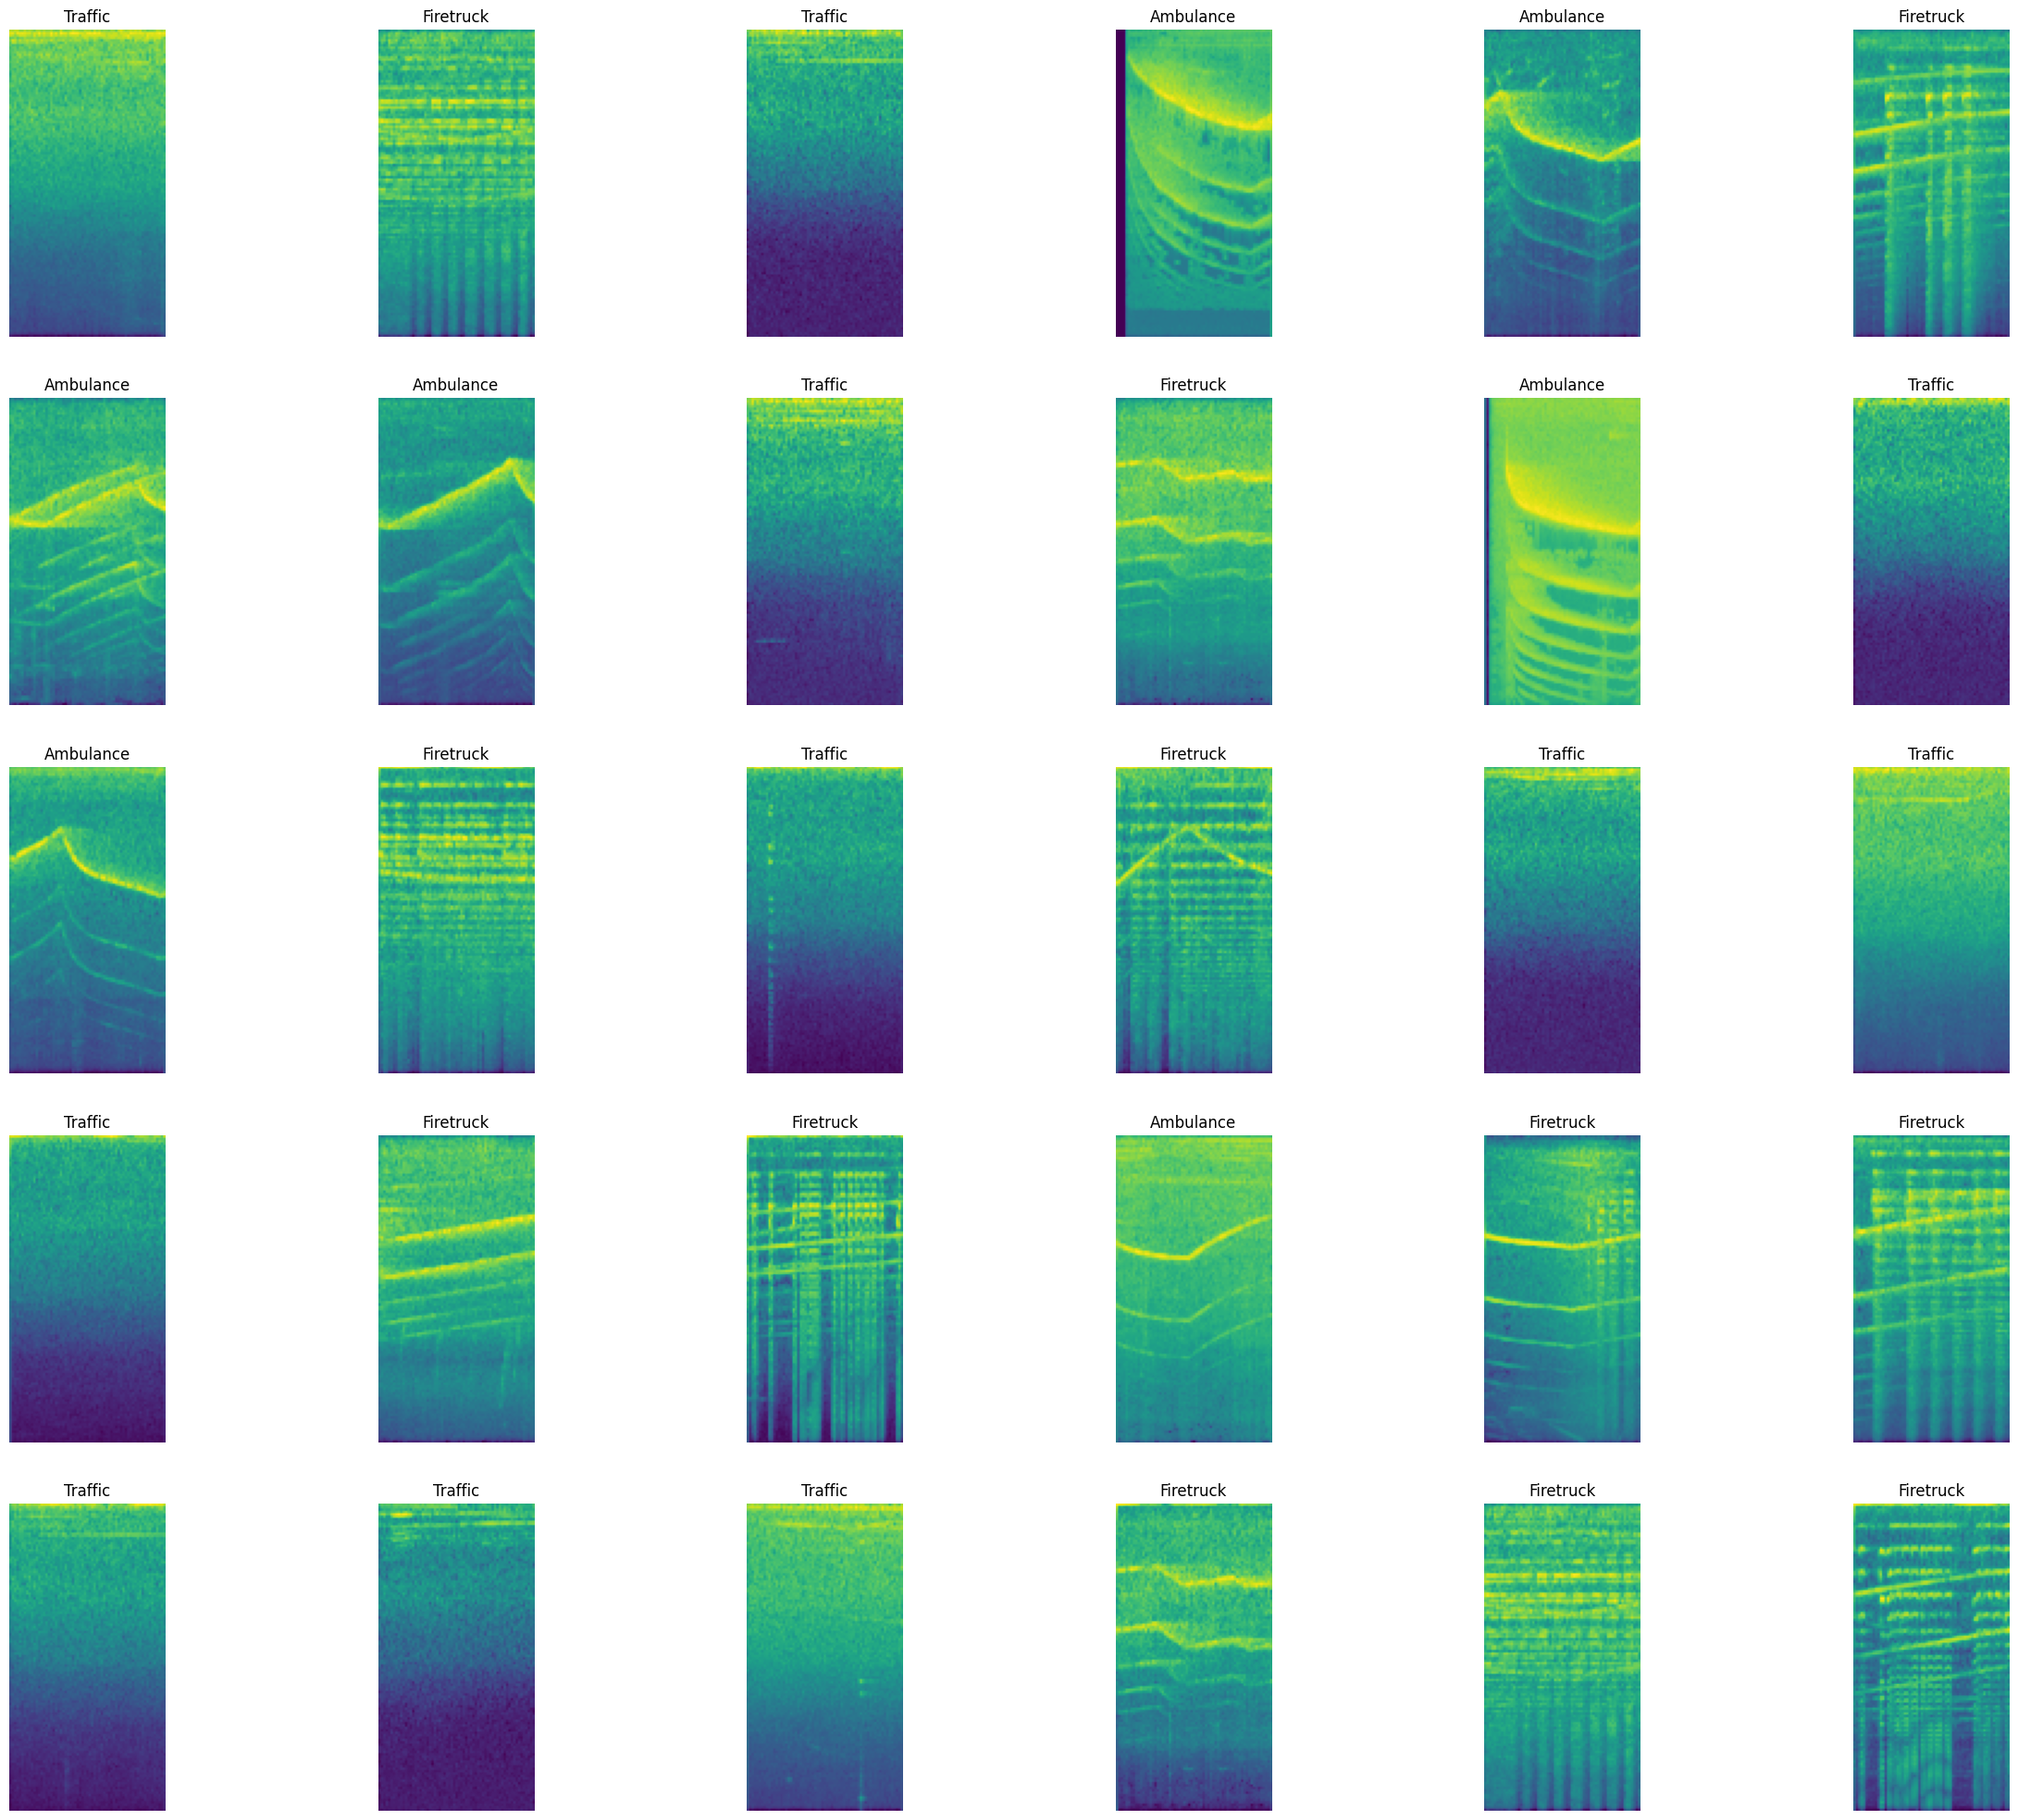

In [ ]:
show_images(train_df['mel'], train_df['label'], class_names=class_names)



---


# 🌐 **Aplicação dos Modelos** 🌐

In [ ]:
def reshape_and_norm(imagem):
    img = (imagem - imagem.min()) / (imagem.max() - imagem.min())
    return img[:,:65].reshape((128,65,1))


In [ ]:
train_df['mel'] = train_df['mel'].apply(reshape_and_norm)
test_df['mel'] = test_df['mel'].apply(reshape_and_norm)


### Redes Neurais Convolucionais

In [ ]:
def def_model():
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=(128,65,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(BatchNormalization())


    model.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(BatchNormalization())


    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(BatchNormalization())

    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(Dropout(0.33))
    model.add(keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model




In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=12),
    keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience=5, min_lr=0.00001),
    keras.callbacks.ModelCheckpoint(
        save_best_only= True,
        filepath= 'best_model.keras'
    )
]
model = def_model()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 128, 65, 32)       832       
                                                                 
 max_pooling2d_96 (MaxPooli  (None, 64, 32, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_96 (Ba  (None, 64, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_98 (Conv2D)          (None, 64, 32, 64)        51264     
                                                                 
 max_pooling2d_97 (MaxPooli  (None, 32, 16, 64)        0         
 ng2D)                                                           
                                                     

In [ ]:
history = model.fit(
    np.array(train_df['mel'].to_list()),
    np.array(train_df['label'].to_list()),
    epochs=100,
    validation_split=0.2,
    callbacks= callbacks,
    batch_size= 15,
)

Epoch 1/100
48/48 [==============================] - 4s 16ms/step - loss: 3.5330e-07 - accuracy: 1.0000 - val_loss: 5.0222e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 1s 14ms/step - loss: 5.3379e-05 - accuracy: 1.0000 - val_loss: 7.6978e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 1s 13ms/step - loss: 0.1887 - accuracy: 0.9833 - val_loss: 39.7539 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 1s 13ms/step - loss: 3.1904 - accuracy: 0.8625 - val_loss: 55.1377 - val_accuracy: 0.6722 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 1s 14ms/step - loss: 1.1961 - accuracy: 0.9236 - val_loss: 9.7799 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 6/100
48/48 [==============================] - 1s 14ms/step - loss: 0.8804 - accuracy: 0.9500 - val_loss: 15.9746 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 7/100
48/48 [==============================] 

In [ ]:
import plotly.express as px
import pandas as pd

his = pd.DataFrame(history.history)
melt = pd.melt(his, ignore_index= False)


In [ ]:
acc = melt[(melt['variable'] == 'accuracy') | (melt['variable'] == 'val_accuracy')]
loss = melt[(melt['variable'] == 'loss') | (melt['variable'] == 'val_loss')]

In [ ]:
fig = px.line(acc, y='value', color= 'variable')

fig.show()

In [ ]:
f## #ig = px.line(loss, y='value', color= 'variable')

fig.show()

In [ ]:
model = keras.models.load_model('best_model.keras')

In [ ]:
test_loss, test_acc = model.evaluate(np.array(test_df['mel'].to_list()), np.array(test_df['label'].to_list()))

5/5 [==============================] - 0s 7ms/step - loss: 0.6346 - accuracy: 0.9600


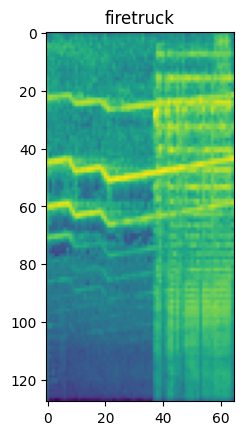

1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

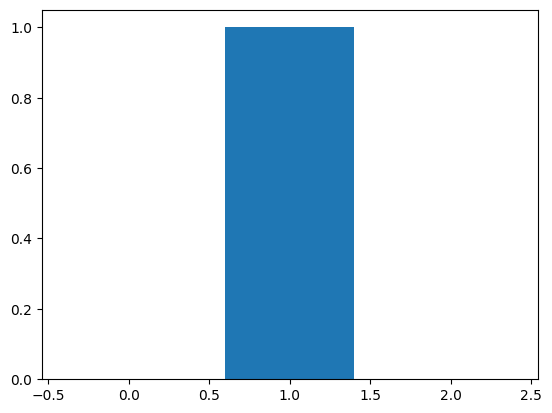

In [ ]:
i = 150
i = np.random.randint(150)

plt.figure()
plt.imshow(test_df['mel'][i])
plt.title(class_names[test_df['label'][i]])
plt.show()

plt.figure()
predictions = model.predict(np.expand_dims(test_df['mel'][i], axis=0)).squeeze()
categories = np.arange(len(predictions))
plt.figure()
plt.bar(categories, predictions)
plt.show()

### LSTM

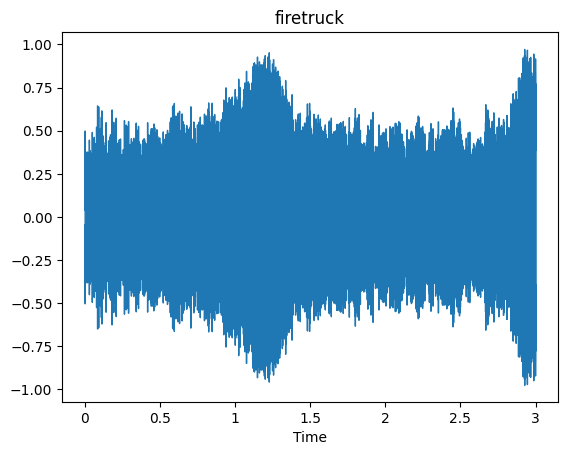

(66150,)


In [ ]:
i = np.random.randint(1050)

plt.figure()
librosa.display.waveshow(train_df['y'][i], sr=train_df['sr'][i])
plt.title(class_names[train_df['label'][i]])
plt.show()

print(train_df['y'][i].shape)

In [ ]:
train_df['y'].apply(lambda x: x.shape).unique()

array([(66150,), (66327,), (66560,)], dtype=object)

In [ ]:
def reshape_and_norm(imagem):
    img = (imagem - imagem.min()) / (imagem.max() - imagem.min())
    return img[:66150]

In [ ]:
train_df['y'] = train_df['y'].apply(reshape_and_norm)
test_df['y'] = test_df['y'].apply(reshape_and_norm)

In [ ]:
def def_lstm():
    model = keras.Sequential()

    model.add(keras.layers.LSTM(64, activation= 'tanh',  input_shape=(66150, 1), implementation=2))
    model.add(Dropout(0.2))

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(Dropout(0.4))

    model.add(keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    model.summary()

    return model


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=12),
    keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience=5, min_lr=0.00001),
    keras.callbacks.ModelCheckpoint(
        save_best_only= True,
        filepath= 'best_model.keras'
    )
]
model = def_lstm()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_80 (Dense)            (None, 64)                4160      
                                                                 
 dense_81 (Dense)            (None, 32)                2080      
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_82 (Dense)            (None, 3)                 99        
                                                                 
Total params: 23235 (90.76 KB)
Trainable params: 2323

In [ ]:
history = model.fit(
    np.array(train_df['y'].to_list()),
    np.array(train_df['label'].to_list()),
    epochs=100,
    validation_split=0.2,
    callbacks= callbacks,
    batch_size= 30,
)

Epoch 1/100
24/24 [==============================] - 49s 2s/step - loss: 1.0992 - accuracy: 0.3278 - val_loss: 1.1020 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 45s 2s/step - loss: 1.0959 - accuracy: 0.3500 - val_loss: 1.1014 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 47s 2s/step - loss: 1.0999 - accuracy: 0.3444 - val_loss: 1.1002 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - 47s 2s/step - loss: 1.0986 - accuracy: 0.3458 - val_loss: 1.1011 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - 47s 2s/step - loss: 1.1005 - accuracy: 0.3375 - val_loss: 1.1019 - val_accuracy: 0.2833 - lr: 0.0010
Epoch 6/100
24/24 [==============================] - 47s 2s/step - loss: 1.0986 - accuracy: 0.3361 - val_loss: 1.1014 - val_accuracy: 0.2778 - lr: 0.0010
Epoch 7/100
24/24 [==============================] - 47s 2s/step - loss: 1.0

In [ ]:
import plotly.express as px
import pandas as pd

his = pd.DataFrame(history.history)
melt = pd.melt(his, ignore_index= False)


In [ ]:
acc = melt[(melt['variable'] == 'accuracy') | (melt['variable'] == 'val_accuracy')]
loss = melt[(melt['variable'] == 'loss') | (melt['variable'] == 'val_loss')]

In [ ]:
fig = px.line(acc, y='value', color= 'variable')

fig.show()

In [ ]:
fig = px.line(loss, y='value', color= 'variable')

fig.show()

In [ ]:
test_loss, test_acc = model.evaluate(np.array(test_df['mel'].to_list()), np.array(test_df['label'].to_list()))

5/5 [==============================] - 0s 8ms/step - loss: 1.1086 - accuracy: 0.3333


acuracia de uma rede aleatória


In [ ]:
def def_lstm():
    model = keras.Sequential()

    model.add(keras.layers.Conv1D(filters=32, kernel_size=23, padding='same', activation='relu', input_shape=(66150, 1)))
    model.add(keras.layers.MaxPooling1D(pool_size=16, strides=16))
    model.add(BatchNormalization())


    model.add(keras.layers.Conv1D(filters=64, kernel_size=23, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=16, strides=16))
    model.add(BatchNormalization())


    model.add(keras.layers.Conv1D(filters=128, kernel_size=23, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=16, strides=16))
    model.add(BatchNormalization())

    model.add(keras.layers.LSTM(64, activation= 'tanh'))
    model.add(Dropout(0.2))

    model.add(keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    model.summary()

    return model


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=12),
    keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience=5, min_lr=0.00001),
    keras.callbacks.ModelCheckpoint(
        save_best_only= True,
        filepath= 'best_model.keras'
    )
]
model = def_lstm()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 66150, 32)         768       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 4134, 32)          0         
 g1D)                                                            
                                                                 
 batch_normalization_114 (B  (None, 4134, 32)          128       
 atchNormalization)                                              
                                                                 
 conv1d_8 (Conv1D)           (None, 4134, 64)          47168     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 258, 64)           0         
 g1D)                                                            
                                                     

In [ ]:
history = model.fit(
    np.array(train_df['y'].to_list()),
    np.array(train_df['label'].to_list()),
    epochs=100,
    validation_split=0.2,
    callbacks= callbacks,
    batch_size= 15,
)

Epoch 1/100
48/48 [==============================] - 6s 54ms/step - loss: 0.4278 - accuracy: 0.8472 - val_loss: 1.8970 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 2s 35ms/step - loss: 0.2601 - accuracy: 0.9097 - val_loss: 2.3046 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 2s 35ms/step - loss: 0.1818 - accuracy: 0.9403 - val_loss: 2.7621 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 2s 35ms/step - loss: 0.1970 - accuracy: 0.9306 - val_loss: 2.7347 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 2s 38ms/step - loss: 0.1534 - accuracy: 0.9486 - val_loss: 3.2525 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 6/100
48/48 [==============================] - 2s 40ms/step - loss: 0.1809 - accuracy: 0.9389 - val_loss: 1.8431 - val_accuracy: 0.5111 - lr: 0.0010
Epoch 7/100
48/48 [==============================] - 2s 38ms/step - lo

In [ ]:
import plotly.express as px
import pandas as pd

his = pd.DataFrame(history.history)
melt = pd.melt(his, ignore_index= False)


In [ ]:
acc = melt[(melt['variable'] == 'accuracy') | (melt['variable'] == 'val_accuracy')]
loss = melt[(melt['variable'] == 'loss') | (melt['variable'] == 'val_loss')]

In [ ]:
fig = px.line(acc, y='value', color= 'variable')

fig.show()

In [ ]:
fig = px.line(loss, y='value', color= 'variable')

fig.show()

In [ ]:
model = keras.models.load_model('best_model.keras')

In [ ]:
test_loss, test_acc = model.evaluate(np.array(test_df['y'].to_list()), np.array(test_df['label'].to_list()))

5/5 [==============================] - 1s 29ms/step - loss: 0.2143 - accuracy: 0.9533


In [ ]:
def def_lstm():
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=(128,65,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(BatchNormalization())

    model.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=[32,2], strides=2))
    model.add(BatchNormalization())

    model.add(keras.layers.Reshape([8,128]))

    model.add(keras.layers.LSTM(64, activation= 'tanh'))
    model.add(Dropout(0.2))

    model.add(keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    model.summary()

    return model


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=12),
    keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience=5, min_lr=0.00001),
    keras.callbacks.ModelCheckpoint(
        save_best_only= True,
        filepath= 'best_model.keras'
    )
]
model = def_lstm()

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_143 (Conv2D)         (None, 128, 65, 32)       832       
                                                                 
 max_pooling2d_143 (MaxPool  (None, 64, 32, 32)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_154 (B  (None, 64, 32, 32)        128       
 atchNormalization)                                              
                                                                 
 conv2d_144 (Conv2D)         (None, 64, 32, 64)        51264     
                                                                 
 max_pooling2d_144 (MaxPool  (None, 32, 16, 64)        0         
 ing2D)                                                          
                                                     

In [ ]:
history = model.fit(
    np.array(train_df['mel'].to_list()),
    np.array(train_df['label'].to_list()),
    epochs=100,
    validation_split=0.2,
    callbacks= callbacks,
    batch_size= 15,
)

Epoch 1/100
48/48 [==============================] - 4s 23ms/step - loss: 0.2792 - accuracy: 0.9014 - val_loss: 1.2721 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 1s 11ms/step - loss: 0.1601 - accuracy: 0.9403 - val_loss: 1.2559 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 0s 9ms/step - loss: 0.1591 - accuracy: 0.9417 - val_loss: 1.4256 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 0s 8ms/step - loss: 0.1179 - accuracy: 0.9597 - val_loss: 1.4099 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0598 - accuracy: 0.9819 - val_loss: 1.2745 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 6/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0598 - accuracy: 0.9778 - val_loss: 1.3522 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 7/100
48/48 [==============================] - 0s 9ms/step - loss: 0

In [ ]:
import plotly.express as px
import pandas as pd

his = pd.DataFrame(history.history)
melt = pd.melt(his, ignore_index= False)


In [ ]:
acc = melt[(melt['variable'] == 'accuracy') | (melt['variable'] == 'val_accuracy')]
loss = melt[(melt['variable'] == 'loss') | (melt['variable'] == 'val_loss')]

In [ ]:
fig = px.line(acc, y='value', color= 'variable')

fig.show()

In [ ]:
fig = px.line(loss, y='value', color= 'variable')

fig.show()

In [ ]:
model = keras.models.load_model('best_model.keras')

In [ ]:
test_loss, test_acc = model.evaluate(np.array(test_df['mel'].to_list()), np.array(test_df['label'].to_list()))

5/5 [==============================] - 1s 9ms/step - loss: 0.0300 - accuracy: 0.9800
